# Final Reward Scores by Model x Reward

This notebook reconstructs **final reward scores** from search logs and aggregates results by task (`model x reward`).

Unit of aggregation for SE:
- SD: 10 prompts
- EDM: 10 classes

Final score extraction rule per sample:
1. If `run_end.best_score` exists and the log has one sample, use it.
2. Otherwise, use the winner score at the last `(timestep_idx, local_iter_idx)` from `candidate_eval`.

Note: for EDM logs, this is typically an estimated score from search-time candidate evaluation.


In [1]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')

from IPython.display import display



In [2]:
# -------- Config --------
EXPERIMENT_NAME = 'inefficiency'
ROOT_LOG_BASE = Path('../logs/search_stats')

MODELS = ['EDM', 'SD']
COL_KEYS = ['brightness', 'compressibility', 'classifier_or_clip']
COL_LABELS = {
    'brightness': 'Brightness',
    'compressibility': 'Compressibility',
    'classifier_or_clip': 'Classifier / CLIP',
}
REWARD_DIR_BY_MODEL = {
    'EDM': {
        'brightness': 'BRIGHTNESS',
        'compressibility': 'COMPRESSIBILITY',
        'classifier_or_clip': 'CLASSIFIER',
    },
    'SD': {
        'brightness': 'BRIGHTNESS',
        'compressibility': 'COMPRESSIBILITY',
        'classifier_or_clip': 'CLIP',
    },
}

ROOT_LOG_BASE / EXPERIMENT_NAME


PosixPath('../logs/search_stats/inefficiency')

In [3]:
def extract_final_scores_from_log(log_path: Path) -> pd.DataFrame:
    cand_rows = []
    run_end_best_score = None

    with log_path.open('r', encoding='utf-8') as f:
        for line in f:
            if not line.strip():
                continue
            try:
                e = json.loads(line)
            except json.JSONDecodeError:
                continue
            et = e.get('event_type')

            if et == 'candidate_eval':
                cand_rows.append({
                    'sample_idx': int(e.get('sample_idx', 0)),
                    'timestep_idx': int(e['timestep_idx']),
                    'local_iter_idx': int(e['local_iter_idx']),
                    'is_winner': bool(e.get('is_winner', False)),
                    'winner_score': e.get('winner_score', None),
                    'score': e.get('score', None),
                })

            elif et == 'run_end' and e.get('best_score') is not None:
                run_end_best_score = float(e['best_score'])

    if len(cand_rows) == 0:
        return pd.DataFrame(columns=['source', 'sample_idx', 'final_score', 'score_source'])

    cdf = pd.DataFrame(cand_rows)
    out = []

    unique_samples = sorted(cdf['sample_idx'].unique().tolist())
    single_sample_log = len(unique_samples) == 1

    for sidx in unique_samples:
        sub = cdf[cdf['sample_idx'] == sidx]

        t_last = int(sub['timestep_idx'].max())
        sub_t = sub[sub['timestep_idx'] == t_last]

        k_last = int(sub_t['local_iter_idx'].max())
        sub_k = sub_t[sub_t['local_iter_idx'] == k_last]

        win = sub_k[sub_k['is_winner'] == True]
        if win.empty:
            # fallback: use highest score row in final (t, k) bucket
            win = sub_k.copy()
            win = win.loc[[win['score'].astype(float).idxmax()]]

        row = win.iloc[0]
        winner_score = row['winner_score']
        if winner_score is None:
            winner_score = row['score']
        winner_score = float(winner_score)

        if single_sample_log and (run_end_best_score is not None):
            final_score = float(run_end_best_score)
            score_source = 'run_end.best_score'
        else:
            final_score = winner_score
            score_source = 'last_t_last_k_winner_score'

        out.append({
            'source': str(log_path),
            'sample_idx': int(sidx),
            'final_score': final_score,
            'score_source': score_source,
        })

    return pd.DataFrame(out)



In [4]:
rows = []

for model in MODELS:
    for col_key in COL_KEYS:
        reward_dir = REWARD_DIR_BY_MODEL[model][col_key]
        log_dir = ROOT_LOG_BASE / EXPERIMENT_NAME / model / reward_dir

        files = sorted(log_dir.rglob('*.jsonl'))
        for fp in files:
            sdf = extract_final_scores_from_log(fp)
            if sdf.empty:
                continue
            sdf['model'] = model
            sdf['reward_key'] = col_key
            sdf['reward_label'] = COL_LABELS[col_key]
            rows.append(sdf)

if len(rows) == 0:
    raise RuntimeError('No final scores could be reconstructed from logs.')

final_scores_df = pd.concat(rows, ignore_index=True)
final_scores_df.head()


,source,sample_idx,final_score,score_source,model,reward_key,reward_label
0,../logs/search_stats/inefficiency/EDM/BRIGHTNE...,0,0.999988,last_t_last_k_winner_score,EDM,brightness,Brightness
1,../logs/search_stats/inefficiency/EDM/BRIGHTNE...,1,1.000000,last_t_last_k_winner_score,EDM,brightness,Brightness
2,../logs/search_stats/inefficiency/EDM/BRIGHTNE...,2,1.000000,last_t_last_k_winner_score,EDM,brightness,Brightness
3,../logs/search_stats/inefficiency/EDM/BRIGHTNE...,3,0.999997,last_t_last_k_winner_score,EDM,brightness,Brightness
4,../logs/search_stats/inefficiency/EDM/BRIGHTNE...,4,0.999961,last_t_last_k_winner_score,EDM,brightness,Brightness


In [5]:
summary = (
    final_scores_df
    .groupby(['model', 'reward_key', 'reward_label'], as_index=False)
    .agg(
        mean_final_score=('final_score', 'mean'),
        se_final_score=('final_score', 'sem'),
        n_units=('final_score', 'count'),
    )
)
summary['se_final_score'] = summary['se_final_score'].fillna(0.0)
summary


,model,reward_key,reward_label,mean_final_score,se_final_score,n_units
0,EDM,brightness,Brightness,0.999994,0.000004,10
1,EDM,classifier_or_clip,Classifier / CLIP,0.999989,0.000009,10
2,EDM,compressibility,Compressibility,0.690867,0.016111,10
3,SD,brightness,Brightness,0.822321,0.012469,10
4,SD,classifier_or_clip,Classifier / CLIP,0.286855,0.006056,10
5,SD,compressibility,Compressibility,0.864785,0.012640,10


In [6]:
# Table view: mean ± SE
table_df = summary.copy()
table_df['mean_pm_se'] = table_df.apply(lambda r: f"{r['mean_final_score']:.6f} ± {r['se_final_score']:.6f}", axis=1)
display(table_df[['model', 'reward_label', 'n_units', 'mean_pm_se']].sort_values(['model', 'reward_label']))


,model,reward_label,n_units,mean_pm_se
0,EDM,Brightness,10,0.999994 ± 0.000004
1,EDM,Classifier / CLIP,10,0.999989 ± 0.000009
2,EDM,Compressibility,10,0.690867 ± 0.016111
3,SD,Brightness,10,0.822321 ± 0.012469
4,SD,Classifier / CLIP,10,0.286855 ± 0.006056
5,SD,Compressibility,10,0.864785 ± 0.012640


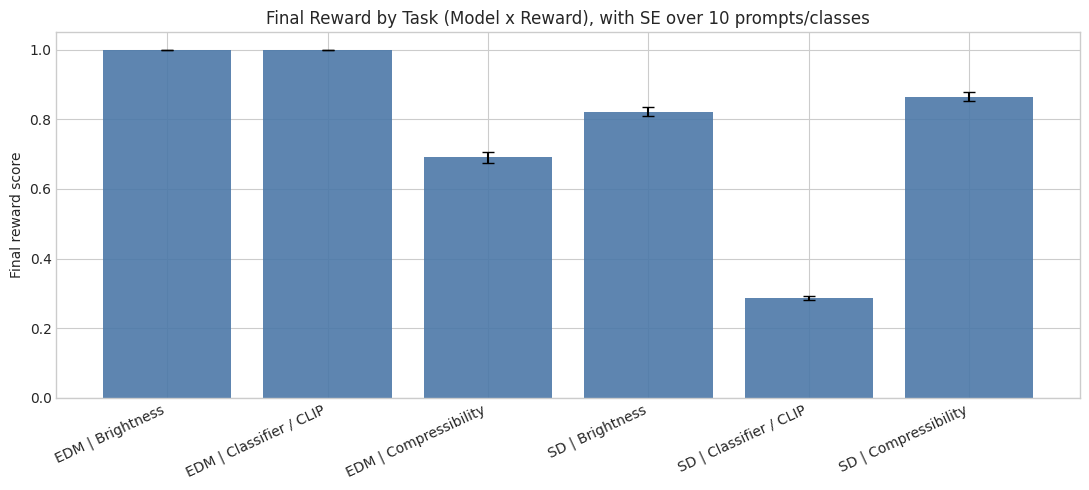

In [7]:
# Plot: one bar per model x reward with SE bars
plot_df = summary.copy()
plot_df['task'] = plot_df['model'] + ' | ' + plot_df['reward_label']
plot_df = plot_df.sort_values(['model', 'reward_key']).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(11, 5))
x = np.arange(len(plot_df))
ax.bar(x, plot_df['mean_final_score'], yerr=plot_df['se_final_score'], capsize=4, color='#4C78A8', alpha=0.9)
ax.set_xticks(x)
ax.set_xticklabels(plot_df['task'], rotation=25, ha='right')
ax.set_ylabel('Final reward score')
ax.set_title('Final Reward by Task (Model x Reward), with SE over 10 prompts/classes')
plt.tight_layout()
plt.show()


In [8]:
# Sanity checks
print('Units per task:')
print(summary[['model', 'reward_label', 'n_units']].sort_values(['model', 'reward_label']).to_string(index=False))

print('\nScore sources used:')
print(final_scores_df.groupby(['model', 'reward_label', 'score_source']).size().rename('count').reset_index().to_string(index=False))


Units per task:
model      reward_label  n_units
  EDM        Brightness       10
  EDM Classifier / CLIP       10
  EDM   Compressibility       10
   SD        Brightness       10
   SD Classifier / CLIP       10
   SD   Compressibility       10

Score sources used:
model      reward_label               score_source  count
  EDM        Brightness last_t_last_k_winner_score     10
  EDM Classifier / CLIP last_t_last_k_winner_score     10
  EDM   Compressibility last_t_last_k_winner_score     10
   SD        Brightness         run_end.best_score     10
   SD Classifier / CLIP         run_end.best_score     10
   SD   Compressibility         run_end.best_score     10
